# А/B-тестирование изменений по улучшению рекомендательной системы

**Задача**: было проведено A/B тестирование по улучшению рекомендательной системы. Для одной группы пользователей ничего не изменилось, для второй - изменилась рекомендательная система. Необходимо оценить корректность проведения теста и проанализировать его результаты. Успешными результатами является увеличение конверсии из посетителя сайта в покупатели.
В случае, если результаты будут признаны успешными, рекомендовать внедрение новой рекомендательной системы всем пользователям.

**Данные**: в нашем распоряжении 4 датасета с календарем маркетинговых исследований за 2020 года, данные новых пользователей, их события и участники тестирования. 

**Техническое задание**:
 - `Название теста`: recommender_system_test
 - `Группы`: А (контрольная), B (новая платёжная воронка)
 - `Дата запуска`: 2020-12-07
 - `Дата остановки набора новых пользователей`: 2020-12-21
 - `Дата остановки`: 2021-01-04
 - `Ожидаемое количество участников теста`: 15% новых пользователей из региона EU
 - `Назначение теста`: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
 - `Ожидаемый эффект`: за 14 дней с момента регистрации в системе  пользователи покажут улучшение каждой метрики (конверсия в просмотр карточек товара, просмотр корзины, покупка) не менее, чем на 5 процентных пунктов.

**План работы**:
Предобработаем данные, проведем проверку корректности проведения теста, проведем исследовательский анализ и проверим результаты A/B тестирования. В результате мы сможем сделать вывод о том, состоялся ли тест и какие дал результаты.

Приступим к предобработке данных.


## Предобработка данных

Импортируем бибиотеки и прочитаем предоставленные таблицы.

In [73]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
import re
from IPython.display import Image

In [2]:
mark_events = pd.read_csv("ab_project_marketing_events.csv")
new_users = pd.read_csv("final_ab_new_users.csv")
events = pd.read_csv("final_ab_events.csv")
participants = pd.read_csv("final_ab_participants.csv")

Напишем функцию, которая выведет всю необходимую первичную информацию и проверит дубликаты. Применим ее к таблицам.

In [3]:
def prev (table, table_name):
    print(f'Информация по таблице {table_name}:')
    print('*'*50)
    table.info()
    print('*'*50)
    print(f'Количество явных дубликатов в таблице {table_name}: {table.duplicated().sum()}')
    display(table.head())

### Календарь маркетинговых событий mark_events 2020 года

In [4]:
prev (mark_events, 'mark_events')

Информация по таблице mark_events:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
**************************************************
Количество явных дубликатов в таблице mark_events: 0


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


В исходных данных 4 столбца и 14 строк.

Столбцы:

 - `name` - название акции
 - `regions` - регионы проведения акции
 - `start_dt` - дата начала
 - `finish_dt` - дата окончания
 
 Пропусков нет.

Поменяем формат даты в start_dt и finish_dt.

In [5]:
mark_events['start_dt'] = pd.to_datetime(mark_events['start_dt'], format='%Y-%m-%d')
mark_events['finish_dt'] = pd.to_datetime(mark_events['finish_dt'], format='%Y-%m-%d')

Посмотрим, какие даты охватывают события.

In [6]:
d1 = mark_events['start_dt'].min()
d2 = mark_events['start_dt'].max()
print(f'Начало маркетинговых событий в промежутке с {d1} по {d2}.')

Начало маркетинговых событий в промежутке с 2020-01-25 00:00:00 по 2020-12-30 00:00:00.


In [7]:
d1 = mark_events['finish_dt'].min()
d2 = mark_events['finish_dt'].max()
print(f'Конец маркетинговых мероприятий в промежутке с {d1} по {d2}.')

Конец маркетинговых мероприятий в промежутке с 2020-02-07 00:00:00 по 2021-01-07 00:00:00.


### Новые пользователи new_users

In [8]:
prev (new_users, 'new_users')

Информация по таблице new_users:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
**************************************************
Количество явных дубликатов в таблице new_users: 0


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


В исходных данных 4 столбца и 61733 строк.

Столбцы:

 - `user_id` — идентификатор пользователя
 - `first_date` — дата регистрации
 - `region` — регион
 - `device` — устройство, с которого пользователь зарегистрировался
 
 Пропусков нет.

Поменяем формат даты в first_date.

In [9]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

Посмотрим, какой период охватывают данные.

In [10]:
d1 = new_users['first_date'].min()
d2 = new_users['first_date'].max()
print(f'Данные охватывают промежуток с {d1} по {d2}.')

Данные охватывают промежуток с 2020-12-07 00:00:00 по 2020-12-23 00:00:00.


### События новых пользователей events

In [11]:
prev (events, 'events')

Информация по таблице events:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
**************************************************
Количество явных дубликатов в таблице events: 0


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


В исходных данных 4 столбца и 440317 строк.

Столбцы:

 - `user_id` — идентификатор пользователя
 - `event_dt` — дата события
 - `event_name` — тип события
 - `details` — доп. данные для события.
 
В столбце details есть пропуски. 

Поменяем формат даты в first_date и создадим новую колонку с датой без времени.

In [12]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')
events['event_dt_cut'] = events['event_dt'].dt.date
events['event_dt_cut'] = pd.to_datetime(events['event_dt_cut'] )

In [13]:
events.head()

,user_id,event_dt,event_name,details,event_dt_cut
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


Посмотрим, какие даты описывают события.

In [14]:
d1 = events['event_dt_cut'].min()
d2 = events['event_dt_cut'].max()
print(f'Данные охватывают промежуток с {d1} по {d2}.')

Данные охватывают промежуток с 2020-12-07 00:00:00 по 2020-12-30 00:00:00.


Посмотрим, какие типы событий присутствуют в таблице.

In [15]:
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

В таблице 4 вида событий:
 - `login` - логин
 - `product_page` - просмотр страницы товара
 - `purchase` - покупка
 - `product_cart` - просмотр корзины

In [16]:
events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

Details заполнены только для вида события purchase и содержат стоимость покупки в долларах.

### Участники теста participants

In [17]:
prev (participants, 'participants')

Информация по таблице participants:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
**************************************************
Количество явных дубликатов в таблице participants: 0


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


В исходных данных 3 столбца и 18268 строк.

Столбцы:

 - `user_id` — идентификатор пользователя
 - `group` — группа пользователя
 - `ab_test` — название теста
 
Пропусков нет.

Проверим, какие еще тесты есть в таблице, кроме нашего.

In [18]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

## Оценка корректности проведения теста

Пройдемся по каждому пункту нашего тех.задания и проверим, соответствуют ли им наши данные.

**1.** Проверим, есть ли в данных тест, который мы должны проверить.

In [19]:
participants.loc[participants['ab_test'] == 'recommender_system_test']['ab_test'].count()

6701

В нужном датасете 6701 строк с нужным тестом. 

**2.** Проверим, есть ли внутри теста нужные группы.

In [20]:
participants.loc[participants['ab_test'] == 'recommender_system_test'].groupby('group').count()

,user_id,ab_test
group,,
A,3824,3824
B,2877,2877


Присутствуют обе группы.

**3.** В соответствии  тех. заданием пользователи должны набираться  с 12 по 21 декабря 20 года. Выберем пользователей из нужного региона и нужного нам теста и проверим даты.

In [21]:
new_users_our = new_users.loc[new_users['region'] == 'EU'].merge(participants.loc[participants['ab_test'] == 'recommender_system_test'], on = 'user_id')

In [22]:
d1 = new_users_our['first_date'].min()
d2 = new_users_our['first_date'].max()
print(f'Данные охватывают промежуток с {d1} по {d2}, что соответствует тех.заданию.')

Данные охватывают промежуток с 2020-12-07 00:00:00 по 2020-12-21 00:00:00, что соответствует тех.заданию.


**4.** Дата остановки теста означает дату, до которой наши пользователи совершали события. В соответствии с тех.заданием они должны совершать события до 4.01, но мы уже проверили, что в дашем датасете есть данные только до 30.12, то есть он не охватывает 5 нужных дней. Необходимо иметь это ввиду в дальнейшем анализе.


**5.** По условиям тех.задания нам необходимо 15% новых участников из региона EU. Соберем всех участников из EU в новом датасете:

In [23]:
participants_eu = new_users.loc[new_users['region'] == 'EU'].merge(participants.loc[participants['ab_test'] == 'recommender_system_test'], on = 'user_id')

In [24]:
participants_eu['user_id'].count()/new_users.loc[new_users['region'] == 'EU'].count()[0]*100

13.725956343202938

Условие по 15% новых участников из EU выполняется.

**6.** Проверим, нет ли пользователей, попавших в оба теста. Для этого создадим вспомогательные таблицы.

In [25]:
recommender_system_test = participants.loc[(participants['ab_test'] == 'recommender_system_test')]
interface_eu_test = participants.loc[(participants['ab_test'] == 'interface_eu_test')]

Объединим их по user_id.

In [26]:
common_users = recommender_system_test.merge(interface_eu_test, on='user_id')
common_users

,user_id,group_x,ab_test_x,group_y,ab_test_y
0,DABC14FDDFADD29E,A,recommender_system_test,A,interface_eu_test
1,04988C5DF189632E,A,recommender_system_test,A,interface_eu_test
2,B3A2485649E4A012,A,recommender_system_test,A,interface_eu_test
3,EAFB9027A27D510C,B,recommender_system_test,A,interface_eu_test
4,5D5E6EE92AF6E9E0,B,recommender_system_test,B,interface_eu_test
...,...,...,...,...,...
1597,C2DC7B6881CE6E30,B,recommender_system_test,B,interface_eu_test
1598,EA29547AB3C0CB9C,B,recommender_system_test,A,interface_eu_test
1599,9A44E27079666291,B,recommender_system_test,A,interface_eu_test
1600,FA86D8DFAD3ADADE,A,recommender_system_test,A,interface_eu_test


Таких пользователей 1602, и удалить их мы не можем, тк они составляют 24% наших данных. Участники, попавшие в групп А второго теста не подтвергались никакому воздействию, поэтому их можно оставить. Посмотрим, сколько пользователей попало в группу В второго теста.

In [27]:
common_users.loc[common_users['group_y'] == 'B']['user_id'].count()

783

Таких пользователей 783 человека, что составляет 11% наших участников. Проверим, как они распределились между нашими группами А и В.

In [28]:
list_of_B = common_users.loc[common_users['group_y'] == 'B']['user_id'].tolist()

In [29]:
b_users = common_users[common_users['user_id'].isin(list_of_B)]
b_users.groupby(['group_x', 'group_y']).size()

group_x  group_y
A        B          439
B        B          344
dtype: int64

Итак, мы получили данные, что пользователи группы В второго теста, на которых оказывалось какое-то влияение, распределились примерно равномерно между нашими группами А и В. Будем считать, что и влияние на них распределилось достаточно равномерно, и оставим этих пользователей в датасете.

**7.** Определим возраст каждого событий, чтобы проверить горизонт событий 14 дней.
Для этого создадим таблицу с датой регистрации и всеми событиями пользователя.

In [30]:
events = events.merge(new_users, on='user_id', how='left')
events.head()

,user_id,event_dt,event_name,details,event_dt_cut,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020-12-07,N.America,iPhone
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-07,EU,iPhone
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020-12-07,N.America,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020-12-07,EU,Android


In [31]:
events['life'] = (events['event_dt_cut'] - events['first_date']).dt.days

Отфильтруем датасет так, чтобы остались только события возрастом не более 14 дней.

In [32]:
events_14 = events.loc[events['life'] <= 14]

Проверим, как распределяются события по дням. 

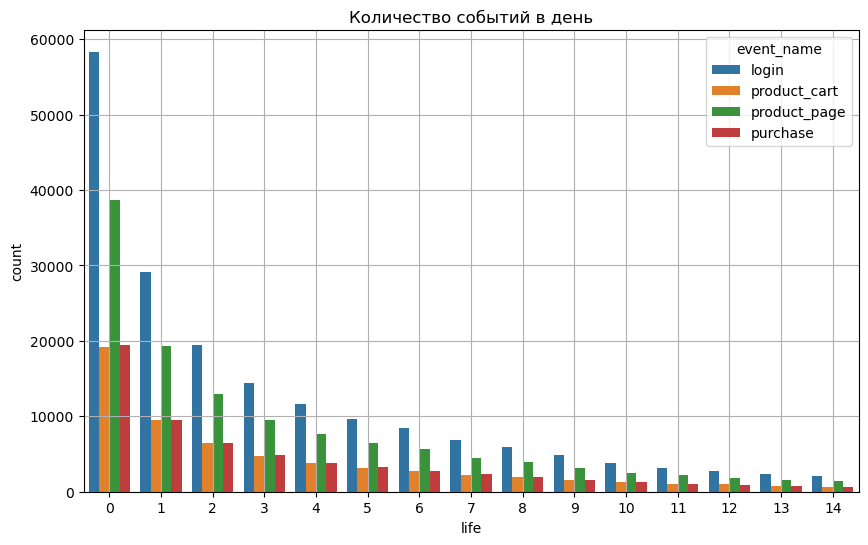

In [33]:
events_grouped = events_14.groupby(['life', 'event_name']).size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='life', y='count', hue='event_name', data=events_grouped, ax=ax)
ax.set_title('Количество событий в день')
ax.grid(True)
plt.show()

Видим, что с каждым днем количество событий значительно уменьшается, и основная масса совершается в первые дни.
Соответственно мы можем оставить всех пользователей, включая тех, кто не успел прожить 14 дней.

Мы проверили все услови технического задания, переходим к исследовательскому анализу данных.

## Исследовальский анализ данных

Создадим отфильтрованную таблицу, которую будем анализировать. В нее попадут только участники нашего тест из EU, зарегистрированные в нужные даты и с событиями не старше 14 дней. 

In [34]:
data = participants.loc[participants['ab_test'] == 'recommender_system_test'].merge(events_14, on='user_id', how='inner').merge(new_users.loc[new_users['region'] == 'EU'], on='user_id', how='inner')

In [35]:
data = data.drop(columns=['first_date_y', 'region_y', 'device_y'])
data.head()

,user_id,group,ab_test,event_dt,event_name,details,event_dt_cut,first_date_x,region_x,device_x,life
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07,EU,PC,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07,EU,PC,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,2020-12-07,EU,PC,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN,2020-12-07,2020-12-07,EU,PC,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,2020-12-20,EU,iPhone,0


Проверим, сколько в итоге у нас событий в каждой группе.

In [36]:
data['group'].value_counts()

A    17977
B     4851
Name: group, dtype: int64

В группе В меньше событий в 3,7 раз.

Проверим, сколько пользователей в каждой группе.

In [37]:
a = data.loc[data['group'] == 'A']['user_id'].nunique()
b = data.loc[data['group'] == 'B']['user_id'].nunique()
print(f'В группе А {a} уникальных пользователей. В группе В {b} уникальных пользователей.')

В группе А 2604 уникальных пользователей. В группе В 877 уникальных пользователей.


### Динамика набора пользователей в группы

Посмотрим на динамику набора пользователей в группы теста.

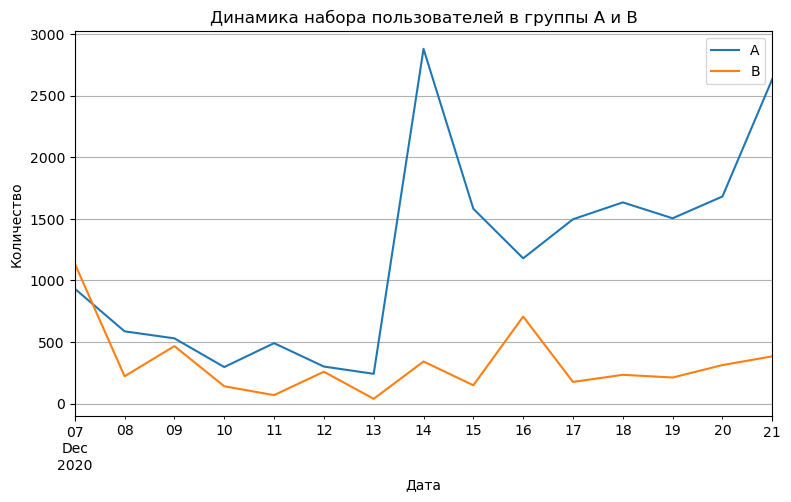

In [38]:
fig, ax = plt.subplots(figsize=(9, 5))
data.loc[data['group'] == 'A'].groupby('first_date_x')['user_id'].count().plot(kind='line', grid = True, label = 'A')
data.loc[data['group'] == 'B'].groupby('first_date_x')['user_id'].count().plot(kind='line',grid = True, label = 'B')
plt.title('Динамика набора пользователей в группы А и В')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()
plt.show()

Проверим цикличность набора пользователей в группы по дням недели. Для этого создадим новую колонку с днем недели зарегистрированного пользователя.

In [39]:
data['reg_weekday'] = pd.DatetimeIndex(data['first_date_x']).weekday
data.head()

,user_id,group,ab_test,event_dt,event_name,details,event_dt_cut,first_date_x,region_x,device_x,life,reg_weekday
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020-12-07,EU,PC,0,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,2020-12-07,EU,PC,0,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,2020-12-07,EU,PC,0,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN,2020-12-07,2020-12-07,EU,PC,0,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,2020-12-20,EU,iPhone,0,6


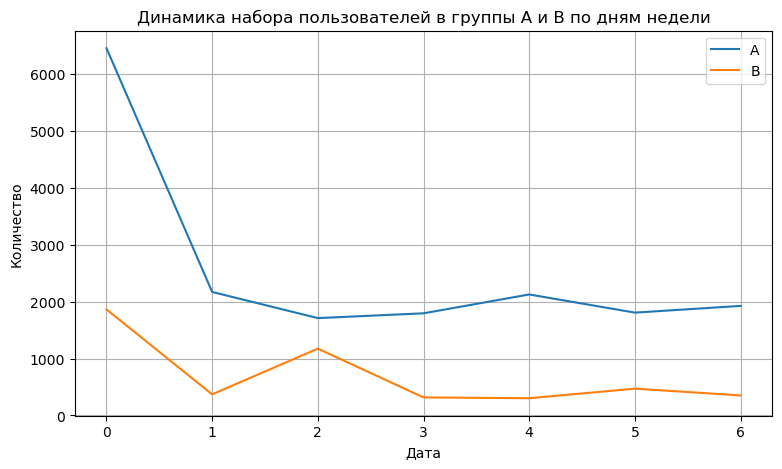

In [40]:
fig, ax = plt.subplots(figsize=(9, 5))
data.loc[data['group'] == 'A'].groupby('reg_weekday')['user_id'].count().plot(kind='line', grid = True, label = 'A')
data.loc[data['group'] == 'B'].groupby('reg_weekday')['user_id'].count().plot(kind='line',grid = True, label = 'B')
plt.title('Динамика набора пользователей в группы А и В по дням недели')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()
plt.show()

Видим, что по дням недели пользователи набирались равномерно: больше всего в понедельник, и далее примерно одинаковые количество по другим дням.

### Количество событий на пользователя

Проверим среднее количество событий на пользователя в каждой группе.

In [41]:
a = data.loc[data['group'] == 'A']['event_name'].count() / data.loc[data['group'] == 'A']['user_id'].nunique()
print(f'Среднее количество событий на пользователя в группе А составляет {a.round(1)} событий.')

Среднее количество событий на пользователя в группе А составляет 6.9 событий.


In [42]:
b = data.loc[data['group'] == 'B']['event_name'].count() / data.loc[data['group'] == 'B']['user_id'].nunique()
print(f'Среднее количество событий на пользователя в группе B составляет {b.round(1)} событий.')

Среднее количество событий на пользователя в группе B составляет 5.5 событий.


In [43]:
print(f'В группе А на {((1-b/a)*100).round(1)}% больше событий на пользователя, чем в группе B.')

В группе А на 19.9% больше событий на пользователя, чем в группе B.


### Пересечение с другими маркетинговыми активностями

Проверим, проходили в наши даты другие маркетинговые мероприятия и оказывали ли они влияние.

Построим график количества событий по дням.

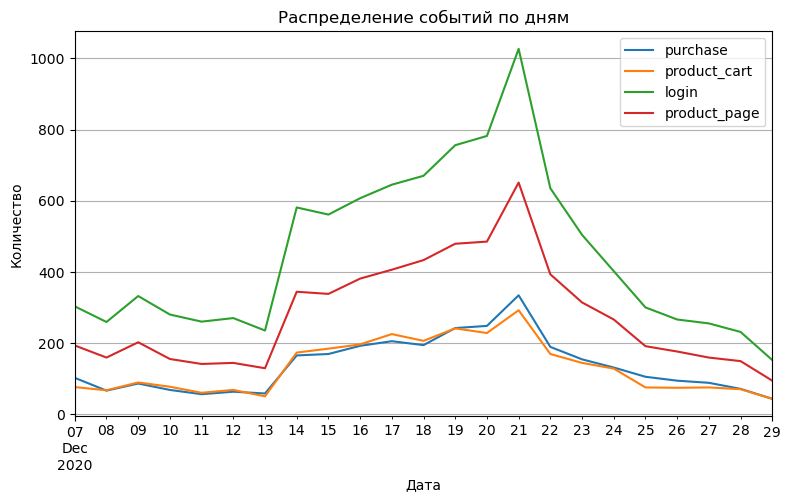

In [44]:
fig, ax = plt.subplots(figsize=(9, 5))
data.loc[data['event_name'] == 'purchase'].groupby('event_dt_cut')['event_name'].count().plot(kind='line', grid = True, label='purchase')
data.loc[data['event_name'] == 'product_cart'].groupby('event_dt_cut')['event_name'].count().plot(kind='line', grid = True, label='product_cart')
data.loc[data['event_name'] == 'login'].groupby('event_dt_cut')['event_name'].count().plot(kind='line', grid = True, label='login')
data.loc[data['event_name'] == 'product_page'].groupby('event_dt_cut')['event_name'].count().plot(kind='line', grid = True, label='product_page')
plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()
plt.show()

Теперь посмотрим на распределение этих событий по группам А и В.

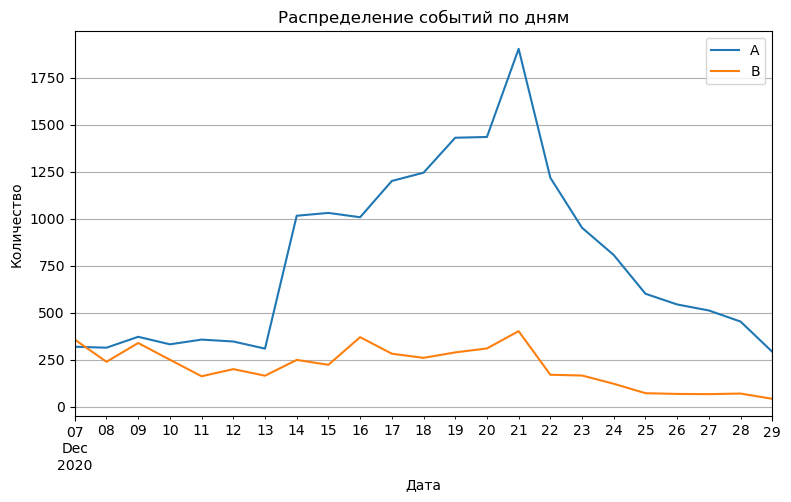

In [45]:
fig, ax = plt.subplots(figsize=(9, 5))
data.loc[data['group'] == 'A'].groupby('event_dt_cut')['event_name'].count().plot(kind='line', grid = True, label='A')
data.loc[data['group'] == 'B'].groupby('event_dt_cut')['event_name'].count().plot(kind='line', grid = True, label='B')
plt.title('Распределение событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()
plt.show()

В группе В события происходили достаточно равномерно, а группе А после 13 декабря количество событий начало увеличиваться с пиком 22 декабря, далее начало плавно снижаться.

Проверим пересечение акций с нашим тестом.

In [46]:
reg = re.compile(r"EU") #регулярное выражение для поиска строк, содержащих "EU"

In [47]:
mark_events.loc[(mark_events['start_dt'] < '2021-01-04') & (mark_events['finish_dt'] > '2020-12-07') & (mark_events['regions'].str.contains(reg))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


С нашим тестом в нашем регионе пересекается одна акция "Christmas&New Year Promo". Началась она 25 января и не оказала влияния на рост количества событий ни одного вида.

### Продуктовые воронки

Построим сводную таблицу по количеству действий по группам А и В и продуктовые воронки.

In [48]:
pivotA = data.loc[data['group'] == 'A'].pivot_table(index='user_id', columns='event_name', aggfunc='nunique')['ab_test'].count()
pivotA = pivotA.reset_index()
pivotA = pivotA.rename(columns={pivotA.columns[1]: "count"})
pivotA


,event_name,count
0,login,2604
1,product_cart,782
2,product_page,1685
3,purchase,833


In [49]:
new_index = [0, 2, 1, 3]
pivotA = pivotA.reindex(new_index)
pivotA['rest']= ((pivotA['count']/ pivotA['count'][0])*100).round(2)
pivotA['rest'] = pivotA['rest'].fillna(100)
pivotA

,event_name,count,rest
0,login,2604,100.00
2,product_page,1685,64.71
1,product_cart,782,30.03
3,purchase,833,31.99


In [50]:
pivotB = data.loc[data['group'] == 'B'].pivot_table(index='user_id', columns='event_name', aggfunc='nunique')['ab_test'].count()
pivotB = pivotB.reset_index()
pivotB = pivotB.rename(columns={pivotB.columns[1]: "count"})
pivotB

,event_name,count
0,login,876
1,product_cart,244
2,product_page,493
3,purchase,249


In [51]:
new_index = [0, 2, 1, 3]
pivotB = pivotB.reindex(new_index)
pivotB['rest']= ((pivotB['count']/ pivotB['count'][0])*100).round(2)
pivotB['rest'] = pivotB['rest'].fillna(100)
pivotB

,event_name,count,rest
0,login,876,100.00
2,product_page,493,56.28
1,product_cart,244,27.85
3,purchase,249,28.42


In [52]:
pivot = pivotA.merge(pivotB, on = 'event_name')
pivot = pivot.rename(columns={'count_x': 'count_a', 'rest_x': 'rest_a', 'count_y': 'count_b', 'rest_y': 'rest_b', }) 
pivot

,event_name,count_a,rest_a,count_b,rest_b
0,login,2604,100.00,876,100.00
1,product_page,1685,64.71,493,56.28
2,product_cart,782,30.03,244,27.85
3,purchase,833,31.99,249,28.42


Построим продуктовую воронку.

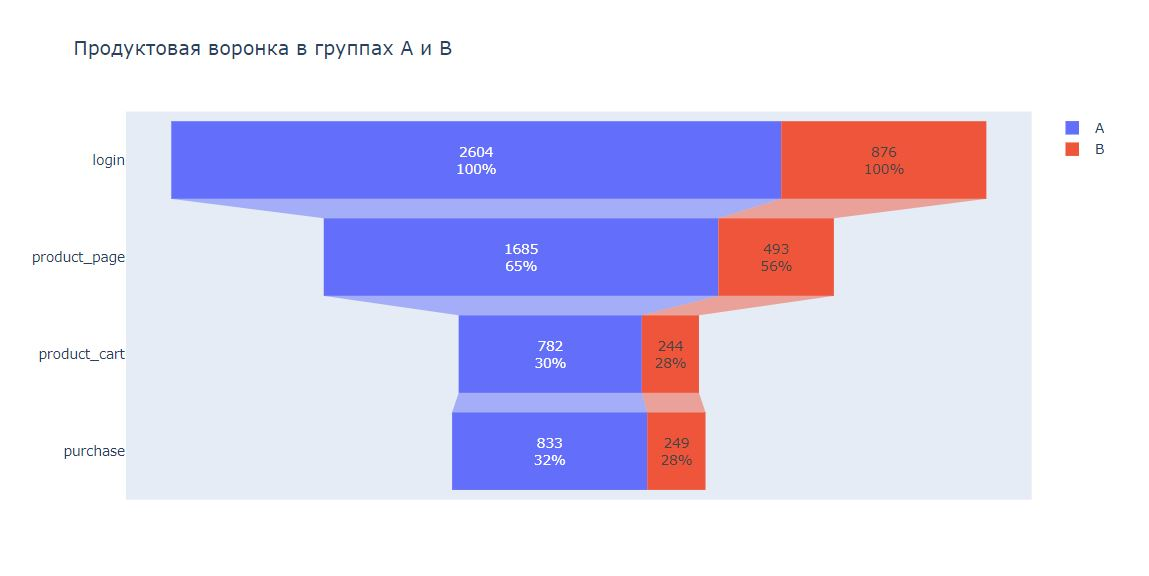

In [75]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = ['login', 'product_page', 'product_cart', 'purchase'],
    x = pivot['count_a'].tolist(),
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B', orientation = "h",
     y = ['login', 'product_page', 'product_cart', 'purchase'],
    x = pivot['count_b'].tolist(),
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title="Продуктовая воронка в группах А и B")

Image("1.jpg")


Исходя из продуктовой воронки, конверсия на каждом этапе в экспериментальной группе не увеличилась, а снизилась. Проверим с помощью статистических методов снизилась ли конверсия или же осталась на том же уровне.

## Оценка результатов A/B-тестирования

Назначим уровень статистической значимости 0.05. Таким образом вероятность ошибки первого рода (отклонение верной нулевой гипотезы) будет составлять 5%. Будет проводиться двусторонний тест.

H0 - между долями нет значимой разницы. Альтернативная гипотеза H1: между долями есть значимая разница.

In [54]:
alpha = .05 #уровень статистической значимости без поправки Бонферрони

Вероятность получения ложного срабатывания возрастает при проведении нескольких проверок гипотез. Нам нужно провести три проверки, поэтому можно воспользоваться поправкой Бонферрони.

Уровень статистической значимости с учетом поправки:

In [55]:
print(f'Уровень стат. значимости с учетом поправки: {0.05/3}')

Уровень стат. значимости с учетом поправки: 0.016666666666666666


In [56]:
alpha = .017  #уровень статистической значимости с учетом поправки Бонферрони

### login - product_page

In [57]:
successes = np.array([pivotA['count'][2], pivotB['count'][2]])
trials = np.array([pivotA['count'][0], pivotB['count'][0]])

In [58]:
p1 = successes[0]/trials[0]  # пропорция успехов в группе А
p2 = successes[1]/trials[1] # пропорция успехов в группе В

In [59]:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) #пропорция успехов в комбинированном датасете
difference = p1 - p2  #разница пропорций в датасетах

Считаем статистику в стандартных отклонениях стандартного нормального распределения: 

In [60]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)  #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

In [61]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
    ) 

p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Таким образом, между долями разницы нет: конверсия от login к product_page одинакова для обеих групп.
Проверим тоже самое для перехода product_page - product_cart.

### product_page - product_cart

In [62]:
successes = np.array([pivotA['count'][1], pivotB['count'][1]])
trials = np.array([pivotA['count'][2], pivotB['count'][2]])

In [63]:
p1 = successes[0]/trials[0]  # пропорция успехов в группе А
p2 = successes[1]/trials[1] # пропорция успехов в группе В

In [64]:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])   #пропорция успехов в комбинированном датасете
difference = p1 - p2   #разница пропорций в датасетах

In [65]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)  #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

In [66]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
    ) 

p-значение:  0.2276722007959906
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


При переходе от product_page к product_cart конверсия в группе В по сравнению с группой А не изменилась.

### product_cart - purchase

In [67]:
successes = np.array([pivotA['count'][3], pivotB['count'][3]])
trials = np.array([pivotA['count'][0], pivotB['count'][0]])

In [68]:
p1 = successes[0]/trials[0]  # пропорция успехов в группе А
p2 = successes[1]/trials[1] # пропорция успехов в группе В

In [69]:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) #пропорция успехов в комбинированном датасете
difference = p1 - p2  #разница пропорций в датасетах

In [70]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)  #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

In [71]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
    ) 

p-значение:  0.04864766695042433
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Разницы между средними значениями двух выборок нет. При проведении теста конверсия покупки не изменилась.

## Выводы

В этом исследованиия мы должны были оценить корректность проведения теста по улучшению рекомендательной системы и проанализировать его результаты. 

Первым этапом мы провели предобработку данных: прочитали все таблицы, проверили пропуски и дубликаты, привели к нужным типам данных, добавили необходимые для дальнейшего анализа столбцы. 

На следующем этапе мы проверили соответствие теста заданному техническому заданию: проверили наличие нужного теста и нужных групп, проверили даты набора и количество участников, изучили пользователей, попавших одновременно в два теста и возраст событий. Мы пришли к выводу, что данные соответствуют техническому заданию и перешли к исследовательскому анализу данных.

В исследовательском анализе мы изучили динамику набора пользователей в группы: пользователи группы В набирались достаточно равномерно, тогда как пользователи группы А набирались одновременно с В до 13 декаря, после чего в группе А начался взрывной рост набора пользователей. Больше всего пользователей набиралось по понедельникам. Также мы изучили количество событий на пользователя: в группе А на 19.9% больше событий на пользователя, чем в группе B. Мы проверили пересечение с другими маркетинговыми активностями и выяснили, что одновременно с нашей акцией проходила еще одна, однако она не оказала влияния на количество событий. После этого мы получили 2 продуктовые воронки для группы А и группы В, по результатам которой увидели, что конверсия событий в экспериментальной группе хуже, чем в контрольной: 32% в контрольной группе дошли до покупки, тогда как в экспериментальной этот показатель составил только 28%.

С помощью статистических тестов мы смогли проверить, корректен ли полученный результат: можем ли мы сделать вывод о том, что в экспериментальной группе конверсия действительно оказалась хуже, или же снижение статистически не значимо. Мы проверили три шага в каждой из групп: login - product_page, product_page - product_cart, product_cart - purchase с учетом поправки Бонферрони. Получили, что уменьшение конверсии на всех шагах статистически не значимо. Таким образом, конверсия всех шагов на одном и том же уровне для обеих групп.

Мы можем сделать вывод, что новая рекомендательная система не сработала и не стоит тратить ресурсы на ее внедрение.